# Bayesian logistic regression:

In [90]:
import jax.numpy as jnp
from jaxtyping import Array, Float
from dataclasses import dataclass

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from coinem.model import AbstractModel

In [91]:
from sklearn.datasets import fetch_covtype
from coinem.dataset import Dataset

# Load in the Covertype dataset
data = fetch_covtype()

# Get the features and target variable
X =  jnp.array(data.data)
y =  jnp.array(data.target == 2).astype(float)


D = Dataset(X, y)

In [109]:
import tensorflow_probability.substrates.jax.distributions as tfd

@dataclass
class LogisticRegression(AbstractModel):
    """Base class for p(θ, x)."""
    
    def log_prob(self, latent: Float[Array, "D 1"], theta: Float[Array, "Q"], data: Dataset) -> Float[Array, ""]:
        """Compute gradient of the objective function at x.

        Args:
            latent (Float[Array, "D"]): Input weights of shape (D,).
            theta (Float[Array, "Q"]): Parameters of shape (Q,).

        Returns:
            Float[Array, ""]: log-probability of the data.
        """
        beta = latent


        # likelihood
        z = jnp.matmul(data.X, beta)
        log_lik = tfd.Bernoulli(logits=z).log_prob(data.y.squeeze()).sum()
        

        # Compute linear predictor.
        z = jnp.matmul(data.X, beta)

        # Prior
        log_prior = tfd.Normal(loc=theta[0], scale=jnp.exp(theta[1])).log_prob(beta.squeeze()).sum().squeeze()


        # Compute log-probability.
        return (log_lik + log_prior) * 1000 / data.X.shape[0]

In [190]:
from coinem.zoo import coin_svgd, pgd
from jax import vmap
from sklearn.metrics import roc_auc_score

likelihood = LogisticRegression()

from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, 
                                                random_state=0)

D = Dataset(Xtrain, ytrain)

# Initialize parameter estimates and particle cloud, all at zero:
import jax.random as jr
key = jr.PRNGKey(123)

# Set approximation parameters:
K = 1000  # Number of steps.
N = 1000  # Number of particles.
th0 = jnp.array([0.0, 0.0])  # Parameter estimate.
X0 = jr.normal(key, (N, D.X.shape[-1]))  # Particle cloud.

def predict_prob(test_inputs, latent):
    """Returns label maximizing the approximate posterior predictive 
    distribution defined by the cloud X, vectorized over feature vectors f.
    """
    s = vmap(lambda x: tfd.Bernoulli(logits=jnp.matmul(test_inputs, x)).mean())(latent).mean(0)
    return s


X_coin, th_coin = coin_svgd(likelihood, D, X0, th0, K, batch_size=100)

coin_auc = roc_auc_score(ytest, predict_prob(Xtest, X_coin[-1]))

pdg_acus = []

for h in jnp.logspace(-15, -3, 20):
    X_pgd, th_pgd = pgd(likelihood, D, X0, th0, K, batch_size=100, latent_step_size=h, theta_step_size=h)
    try:
        pdg_auc = roc_auc_score(ytest, predict_prob(Xtest, X_pgd[-1]))
    except:
        pdg_auc = 0

    pdg_acus.append(pdg_auc)

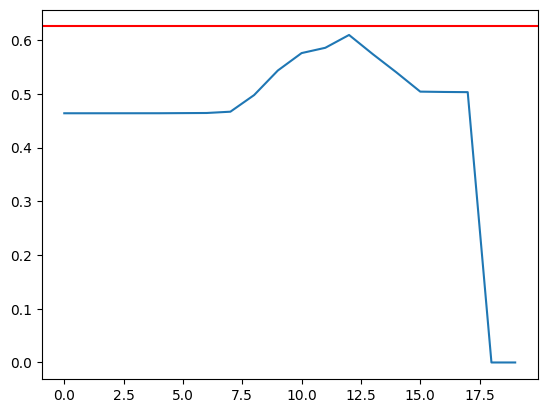

In [192]:
plt.axhline(coin_auc, color='r')
plt.plot(pdg_acus)